# Data generation tutorial -- pre-optimized dataset

This tutorial demonstrates data generation with a pre-optimization. 
This is often required if the target solutions are sparse in the parameter space. 

Here we implement a generation and selection process that has tendency to generate high-R solutions, but which conserves a high degree of randomness to avoid a too strong bias of the dataset.


## Install (colab) and import modules

In [3]:
import time

import numpy as np
import PyMoosh.core as pym
import matplotlib.pyplot as plt
import h5py

import helper

2023-06-30 12:37:10.912940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 12:37:11.433269: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dataset with pre-optimization

Often the design solutions are sparse in the parameter space. In multilayer stacks for instance, especially for high numbers of layers, high reflectivity solutions are in fact very rare. Random assemblies of layers will basically always have a weak reflectivity. The average peak reflectivity each spectrum in 50.000 random generated structures was around 50%.
Hence a network aiming for designing high-R solutions will probably not learn how such solutions need to be constructed from the fully random dataset.

We will pre-optimize the dataset, such that many samples go already in the desired direction. This could be done with sohpisticated optimization methods, but often the goal is specifically to avoid complicated algorithms. So here we demonstrate how such dataset can be designed with a simple approach. It is also important to have a variation-rich, not too biased dataset so the network learns the problem in a general manner. 

Therefore we base our approach on random generation with an additional, soft high-R selectivity.

*Note:* sample-by-sample parallelization is not possible because we will use iterative techniques, but of course the full process could be run multiple times in parallel.

## Define random limits and other config

In [4]:
# init RNG
rng = np.random.default_rng()

# config; random range definitions
N_samples = 50000
N_max_nosuccess = 200  # nr of non-successful layer-replacements until restart

wavelength = 532.0
N_layers = 10
d_limits = [20, 180]             # in nm
eps_limits =  [1.3**2, 2.5**2]

# helper to generate random layer sequence
def gen_random_layerstack(N_layers, lim_d, lim_eps, rng):
    d = rng.random(size=N_layers) * np.diff(lim_d) + lim_d[0]
    eps = rng.random(size=N_layers) * np.diff(lim_eps) + lim_eps[0]
    
    return d, eps

## Generate random samples

We iteratively increase the reflectivity while maintaining randomness in the procedure to avoid a too biased dataset. Our process is as follows

1. generate fully random layer structure design
2. calculate reflectivity and add to dataset
3. loop:

    1. replace a single, random layer by a new, random layer
    2. calculate reflectivity and add to dataset
    3. If R is better, keep new design, if R is worse, discard the new layer
    4. if `N_max_nosuccess` iterations without improvement, restart with fully random design
    
In this way, a part of the dataset still is fully random, while an important amount of designs also has high reflectivity.

In [5]:
# do iteration
conf_list = []
geo_data = []
thick = []
mat = []
R_data = []

R_former = 0
N_nosucces = 0
geo_former = None

t0 = time.time()
for i in range(N_samples):
    d, eps = gen_random_layerstack(N_layers, d_limits, eps_limits, rng)
    geo_new = np.array([d, eps])
    
    if geo_former is not None and N_nosucces < N_max_nosuccess:
        # replace a single layer
        i_layer_rnd = np.random.randint(N_layers)
        geo = geo_former.copy()
        geo[:, i_layer_rnd] = geo_new[:, i_layer_rnd]
    else:
        # start new iteration
        print("#{}: init new stack. Best of previous cycle R={:.3f}".format(i, R_former))
        R_former = 0
        N_nosucces = 0
        geo_former = geo_new
        geo = geo_new
        
    R = helper.calc_R(*geo, [wavelength])
    R = R[0]   # single wavelength
    
    # has improved: replace former geometry by new one.
    # otherwise just increment non-success counter
    if R > R_former:
        R_former = R
        geo_former = geo
        N_nosucces = 0
    else:
        N_nosucces += 1
    
    # add latest simulation to dataset
    conf_list.append([d, eps, wavelength])
    geo_data.append(geo)
    thick.append(geo[0])
    mat.append(geo[1])
    R_data.append(R)
Dt = time.time()-t0

print("global maximum reflectivity = {:.3f}".format(np.max(R_data)))
print("time for {:} samples: {:.2f}s   (={:.2f}ms per sample)".format(
    len(R_data), Dt, 1000*(Dt)/len(R_data)))

# convert to numpy
geo_data = np.array(geo_data)
geo_data = np.moveaxis(geo_data, 1, 2)
thick = np.array(thick)
mat = np.array(mat)
R_data = np.array(R_data)

#0: init new stack. Best of previous cycle R=0.000
#1226: init new stack. Best of previous cycle R=0.980
#2261: init new stack. Best of previous cycle R=0.971
#3138: init new stack. Best of previous cycle R=0.977
#4079: init new stack. Best of previous cycle R=0.940
#5519: init new stack. Best of previous cycle R=0.980
#6483: init new stack. Best of previous cycle R=0.990
#7090: init new stack. Best of previous cycle R=0.975
#8074: init new stack. Best of previous cycle R=0.980
#8927: init new stack. Best of previous cycle R=0.971
#10234: init new stack. Best of previous cycle R=0.977
#11556: init new stack. Best of previous cycle R=0.993
#12263: init new stack. Best of previous cycle R=0.965
#13350: init new stack. Best of previous cycle R=0.974
#14750: init new stack. Best of previous cycle R=0.994
#15872: init new stack. Best of previous cycle R=0.937
#16878: init new stack. Best of previous cycle R=0.976
#18388: init new stack. Best of previous cycle R=0.994
#19521: init new stack.

### Analyze average reflectivity

The average reflectivity is significantly higher than the peak R per spectrum in the fully random case (where we furthermore evaluated a full spectrum per design):

In [6]:
print('Mean maximum R in the spectra of the random dataset: {:.3f} +/- {:.3f}'.format(
    np.mean(R_data), np.std(R_data)))

Mean maximum R in the spectra of the random dataset: 0.842 +/- 0.194


### Calculate spectra for some samples

It is important to understand the data and to have some intuition for it. Let's plot a few random picks of the samples:

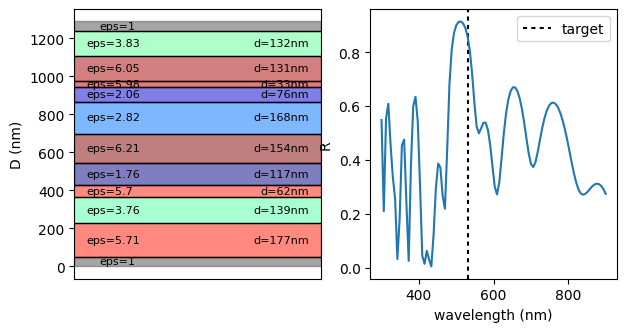

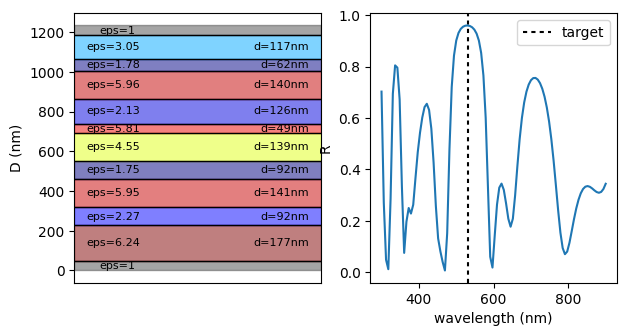

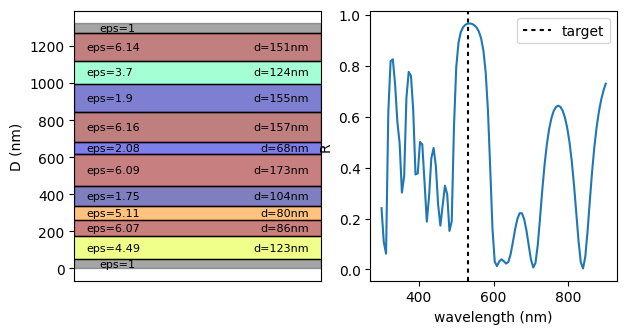

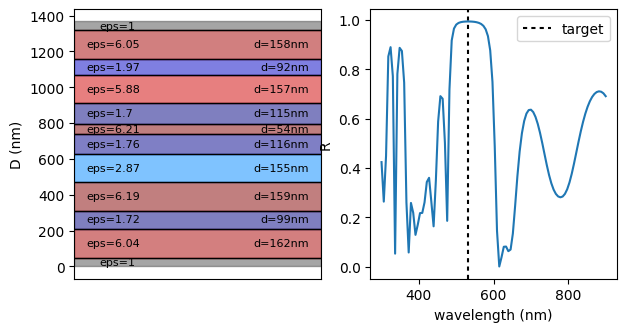

In [8]:
from helper import plot_stack

idx_list = np.concatenate([
    np.random.randint(len(geo_data), size=3), # 3 random designs
    [np.argmax(R_data)]   # global max R
])

for idx in idx_list:
    wl_spec= np.linspace(300, 900, 100)
    D, mat = geo_data[idx].T
    R_spec = helper.calc_R(D, mat, wl_spec)

    plt.figure(figsize=(7, 3.5))
    plt.subplot(121)
    plot_stack(mat, D, [mat.min(), mat.ptp()])
    plt.subplot(122)
    plt.axvline(wavelength, label='target', color='k', dashes=[2,2])
    plt.plot(wl_spec, R_spec)
    plt.legend()
    plt.xlabel('wavelength (nm)')
    plt.ylabel('R')
    plt.show()

### Save dataset to .h5 file

Finally we save the dataset to a hdf5 file.

In [9]:
f = h5py.File("datasets/dataset2_R_optimized.h5", "w")

dset_wl = f.create_dataset("wavelengths", data=[wavelength], compression='lzf')
dset_geo = f.create_dataset("geo", data=geo_data, compression='lzf')
dset_geo_mat = f.create_dataset("mat", data=mat, compression='lzf')
dset_geo_thick = f.create_dataset("thick", data=thick, compression='lzf')
dset_R = f.create_dataset("R", data=R_data, compression='lzf')

f.close()